# Bayesian Optimization (4)

I ran my Bayesian optimization code on the goalObjs treatment plan, which had six parameters corresponding to six max dose or max DVH objectives. The score was the unweighted sum of the percent decrease from the max value for each of these objectives.

I ran the script for three different parameter ranges: 0-100%, 25-100%, and 50-100% of the max values for each objective. When a treatment plan was infeasible for RayStation, I returned score of 100. This only happened for the 0-100% run, and I think it made it more difficult to approximate the score function. Ideally, we would like to be able to identify the best parameter ranges so that we don't have to worry about plan infeasibility at all, while still getting the best plans possible.

## Objective Terms

idx | Name | Description | FunctionType | DoseValue | PercentVolume | Weight
-|-|-|-|-|-|-
0 | PTV | Min Dose 4800 cGy | MinDose | 4800 | 0 | 1
1 | PTV | Max Dose 6200 cGy | MaxDose | 6200 | 0 | 1
2 | Rib | Max DVH 3200 cGy to 0.27% volume | MaxDvh | 3200 | 0.27 | 1
3 | SpinalCanal | Max DVH 2080 cGy to 0.67% volume | MaxDvh | 2080 | 0.67 | 1
4 | Heart | Max DVH 2800 to 2% volume | MaxDvh | 2800 | 1.84 | 1
5 | Chestwall_L | Max DVH 3000 cGy to 2.04% volume | MaxDvh | 3000 | 2.04 | 1
6 | Lungs | Max DVH 2000 cGy to 10% volume | MaxDvh | 2000 | 10 | 1

In [35]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
import utils

In [129]:
fun_approved = -2.4151106428641933
stats_approved = np.load('approved/stats.npy', allow_pickle=True).item()
dvh_approved = np.load('approved/dvh.npy', allow_pickle=True).item()
objs_approved = np.load('approved/objs.npy', allow_pickle=True).item()

In [36]:
colors = cm.tab10.colors
roi_list = ['PTV', 'Rib', 'SpinalCanal', 'Heart', 'Chestwall_L', 'Lungs']

In [80]:
def plot_opt(func_vals):
    idx = np.argmin(func_vals)
    plt.plot(func_vals)
    plt.plot(idx, func_vals[idx], '.')
    plt.xlabel('Iteration')
    plt.ylabel('Plan Score')
    plt.legend(['Iterates', 'Best Plan'], bbox_to_anchor=(1, 1));

In [86]:
def plot_pars(x_iters):
    par_list = []
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for ii in range(len(roi_list)):
        par_list.append(x_iters[:, ii])
        ax[1].plot(x_iters[:, ii])
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Parameter Value')
    plt.legend(roi_list, bbox_to_anchor=(1, 1))
    ax[0].boxplot(par_list)
    ax[0].set_xticklabels(roi_list, rotation=90)
    ax[0].set_ylabel('Parameter Value');

In [136]:
def plot_dvh(dvh):
    idx = 0
    handle_list = []
    for roi in roi_list:
        handle, = plt.plot(dvh_approved['Dose'], 100*dvh_approved[roi], color=colors[idx])
        plt.plot(dvh['Dose'], 100*dvh[roi], '--', color=colors[idx])
        handle_list.append(handle)
        idx += 1
    plt.xlabel('Dose (cGy)')
    plt.ylabel('Volume (%)')
    plt.legend(handles=handle_list, labels=roi_list, bbox_to_anchor=(1, 1));

In [132]:
def get_stats(fun, objs):
    print(f'Approved Score: {fun_approved:.4f}, Result Score: {fun:4f}, % Change: {100*(fun_approved - fun)/fun_approved:.4f}')
    for roi in roi_list:
        app = objs_approved[roi][-1]['ResultValue']
        res = objs[roi][-1]['ResultValue']
        print(f'{roi} Approved: {app:.4f}, Result: {res:.4f}, % Change: {100*(res - app)/app:.4f}')

# 0-100% of parameter values

In [206]:
fun_full = np.load('6_12_full/fun.npy')
func_vals_full = np.load('6_12_full/func_vals.npy')
x_full = np.load('6_12_full/x.npy')
x_iters_full = np.load('6_12_full/x_iters.npy')
stats_full = np.load('6_12_full/stats.npy', allow_pickle=True).item()
dvh_full = np.load('6_12_full/dvh.npy', allow_pickle=True).item()
objs_full = np.load('6_12_full/objs.npy', allow_pickle=True).item()

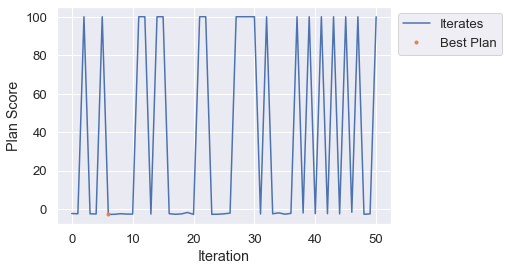

In [85]:
# Optimization
plot_opt(func_vals_full)

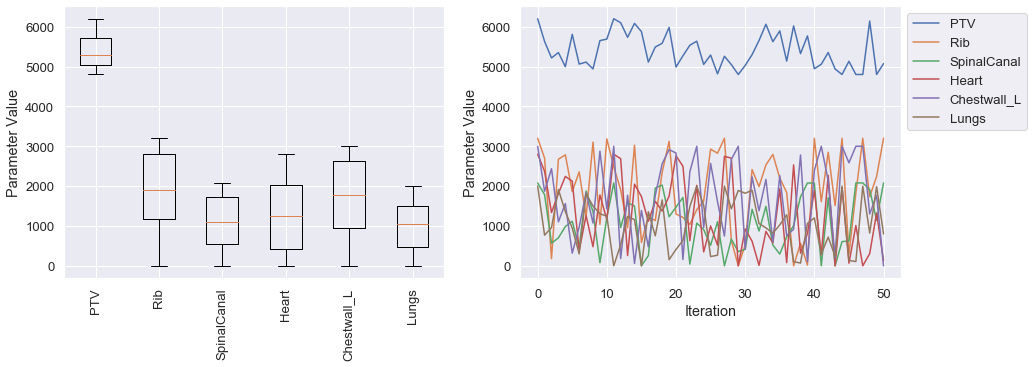

In [87]:
# Parameters
plot_pars(x_iters_full)

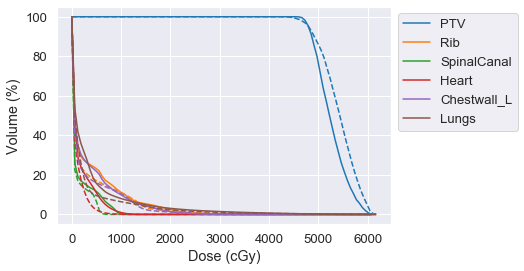

In [137]:
# DVH
plot_dvh(dvh_full)

Approved Score: -2.4151, Result Score: -2.768201, % Change: -14.6201
PTV Approved: 6076.1250, Result: 6169.8232, % Change: 1.5421
Rib Approved: 2620.9576, Result: 3202.3824, % Change: 22.1837
SpinalCanal Approved: 946.8539, Result: 603.7567, % Change: -36.2355
Heart Approved: 889.2485, Result: 531.8349, % Change: -40.1928
Chestwall_L Approved: 1863.7082, Result: 1580.8158, % Change: -15.1790
Lungs Approved: 783.5539, Result: 457.5489, % Change: -41.6059


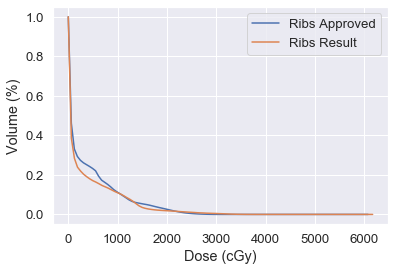

In [138]:
# Stats
get_stats(fun_full, objs_full)

# Look at rib more, only OAR that did worse
plt.plot(dvh_approved['Dose'], dvh_approved['Rib'])
plt.plot(dvh_full['Dose'], dvh_full['Rib'])
plt.xlabel('Dose (cGy)')
plt.ylabel('Volume (%)')
plt.legend(['Ribs Approved', 'Ribs Result']);

# 25-100% of parameter values

In [101]:
fun_quarter = np.load('6_12_quarter/fun.npy')
func_vals_quarter = np.load('6_12_quarter/func_vals.npy')
x_quarter = np.load('6_12_quarter/x.npy')
x_iters_quarter = np.load('6_12_quarter/x_iters.npy')
stats_quarter = np.load('6_12_quarter/stats.npy', allow_pickle=True).item()
dvh_quarter = np.load('6_12_quarter/dvh.npy', allow_pickle=True).item()
objs_quarter = np.load('6_12_quarter/objs.npy', allow_pickle=True).item()

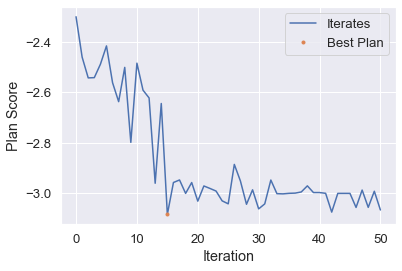

In [102]:
# Optimization
plot_opt(func_vals_quarter)

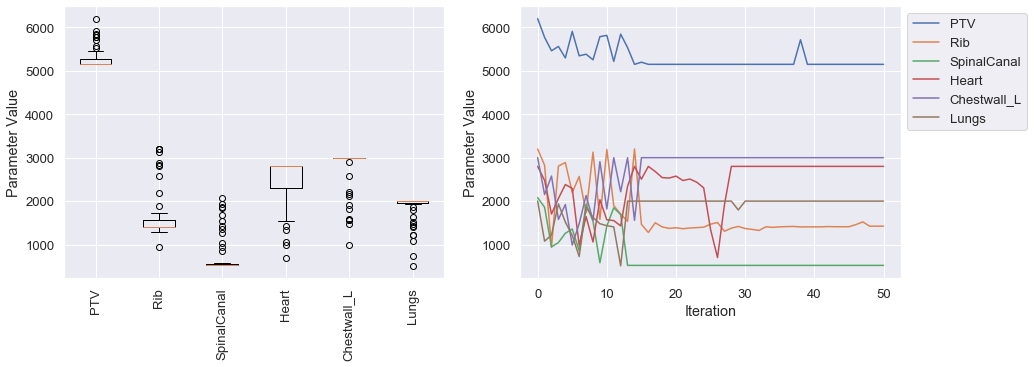

In [104]:
# Parameters
plot_pars(x_iters_quarter)

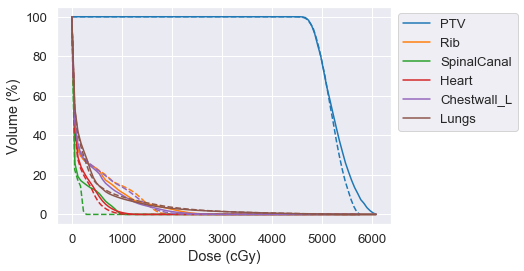

In [139]:
# DVH
plot_dvh(dvh_quarter)

Approved Score: -2.4151, Result Score: -3.083009, % Change: -27.6550
PTV Approved: 6076.1250, Result: 5748.9258, % Change: -5.3850
Rib Approved: 2620.9576, Result: 1887.1611, % Change: -27.9973
SpinalCanal Approved: 946.8539, Result: 242.8505, % Change: -74.3519
Heart Approved: 889.2485, Result: 754.3319, % Change: -15.1720
Chestwall_L Approved: 1863.7082, Result: 1727.4238, % Change: -7.3125
Lungs Approved: 783.5539, Result: 876.0789, % Change: 11.8084


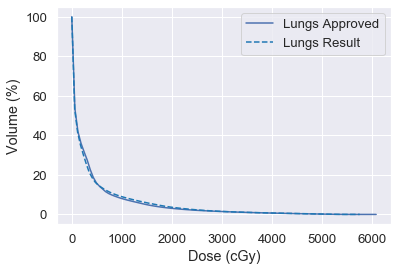

In [172]:
# Stats
get_stats(fun_quarter, objs_quarter)

# Look at lungs more, only OAR that did worse
plt.plot(dvh_approved['Dose'], 100*dvh_approved['Lungs'])
plt.plot(dvh_quarter['Dose'], 100*dvh_quarter['Lungs'], '--', color=colors[0])
plt.xlabel('Dose (cGy)')
plt.ylabel('Volume (%)')
plt.legend(['Lungs Approved', 'Lungs Result']);

# 50-100% of parameter values

In [149]:
fun_half = np.load('6_12_half/fun.npy')
func_vals_half = np.load('6_12_half/func_vals.npy')
x_half = np.load('6_12_half/x.npy')
x_iters_half = np.load('6_12_half/x_iters.npy')
stats_half = np.load('6_12_half/stats.npy', allow_pickle=True).item()
dvh_half = np.load('6_12_half/dvh.npy', allow_pickle=True).item()
objs_half = np.load('6_12_half/objs.npy', allow_pickle=True).item()

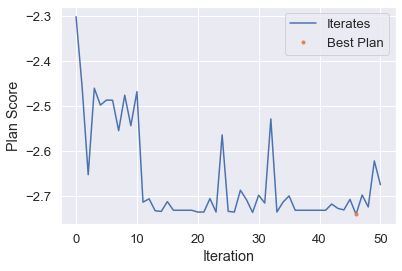

In [150]:
# Optimization
plot_opt(func_vals_half)

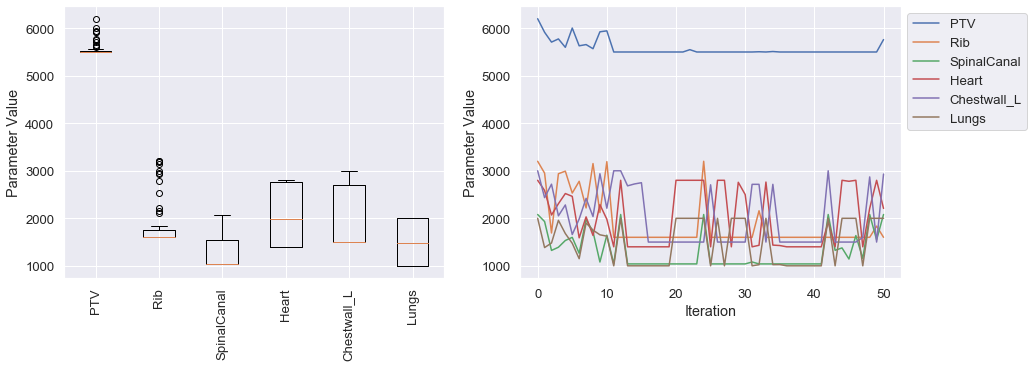

In [151]:
# Parameters
plot_pars(x_iters_half)

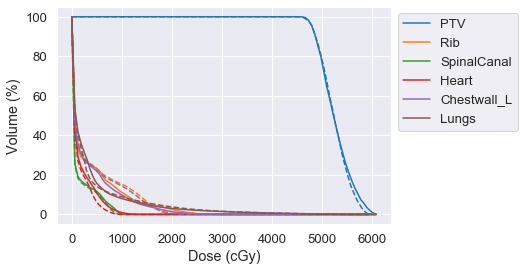

In [152]:
# DVH
plot_dvh(dvh_half)

Approved Score: -2.4151, Result Score: -2.740948, % Change: -13.4916
PTV Approved: 6076.1250, Result: 5931.4932, % Change: -2.3803
Rib Approved: 2620.9576, Result: 1954.5512, % Change: -25.4261
SpinalCanal Approved: 946.8539, Result: 874.1477, % Change: -7.6787
Heart Approved: 889.2485, Result: 700.0242, % Change: -21.2791
Chestwall_L Approved: 1863.7082, Result: 1761.3625, % Change: -5.4915
Lungs Approved: 783.5539, Result: 868.3398, % Change: 10.8207


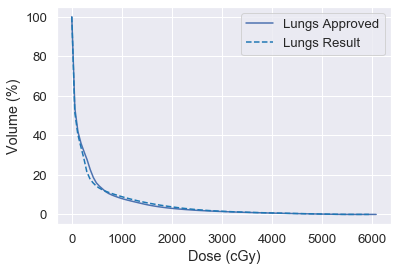

In [171]:
# Stats
get_stats(fun_half, objs_half)

# Look at lungs more, only OAR that did worse
plt.plot(dvh_approved['Dose'], 100*dvh_approved['Lungs'])
plt.plot(dvh_half['Dose'], 100*dvh_half['Lungs'], '--', color=colors[0])
plt.xlabel('Dose (cGy)')
plt.ylabel('Volume (%)')
plt.legend(['Lungs Approved', 'Lungs Result']);

# Comparison

## Objective Terms

I kept the PTV min dose parameter at 4800, since this is what I used to normalize each resulting plan. All other parameteters have been tuned to get the best plan score.

idx | Name | Description | FunctionType | DoseValue | PercentVolume | Weight
-|-|-|-|-|-|-
0 | PTV | Min Dose 4800 cGy | MinDose | 4800 | 0 | 1
1 | PTV | Max Dose 6200 cGy | MaxDose | 6200 | 0 | 1
2 | Rib | Max DVH 3200 cGy to 0.27% volume | MaxDvh | 3200 | 0.27 | 1
3 | SpinalCanal | Max DVH 2080 cGy to 0.67% volume | MaxDvh | 2080 | 0.67 | 1
4 | Heart | Max DVH 2800 to 2% volume | MaxDvh | 2800 | 1.84 | 1
5 | Chestwall_L | Max DVH 3000 cGy to 2.04% volume | MaxDvh | 3000 | 2.04 | 1
6 | Lungs | Max DVH 2000 cGy to 10% volume | MaxDvh | 2000 | 10 | 1

## Parameters

These are the DoseValue parameters used for each plan. The ranges considered are in brackets, and the values that lie on the lower or upper boundary are in bold. Having many parameters on the lower boundary indicates we could make further improvements if we lowered the boundary value. I also included results from the random samples I took using both the full and half parameter ranges (best out of 100 plans sampled).

Plan | PTV | Rib | SpinalCanal | Heart | Chestwall_L | Lungs
-|-|-|-|-|-|-
Full | 5062 [4801, 6200] | 2358 [0, 3200] | 450 [0, 2080] | 379 [0, 2800] | 972 [0, 3000] | 299 [0, 2000]
Full (rand) | 4848 [4801, 6200] | 1140 [0, 3200] | 438 [0, 2080] | 2415 [0, 2800] | 2838 [0, 3000] | 534 [0, 2000]
Quarter | 5199 [5150, 6200] | 1465 [800, 3200] | **520** [520, 2080] | 2506 [700, 2800] | **3000** [750, 3000] | **2000** [500, 2000]
Half | **5500** [5500, 6200] | **1600**  [1600, 3200] | 1637 [1040, 2080] | **2800** [1400, 2800] | **1500** [1500, 3000] | **2000** [1000, 2000]
Half (rand) | 5937 [5500, 6200] | 1651 [1600, 3200] | 1092 [1040, 2080] | 2643 [1400, 2800] | 2590 [1500, 3000] | 1390 [1000, 2000]

## Results

Dose values achieved by each plan. Best values over all plans are in bold.

Plan | Score | PTV | Rib | SpinalCanal | Heart | Chestwall_L | Lungs
-|-|-|-|-|-|-|-
Approved | -2.4151 | 6076.1250 | 2620.9576 | 946.8539 | 889.2485 | 1863.7082 | 783.5539
Full | -2.768201 | 6169.8232 | 3202.3824 | 603.7567 | **531.8349** | **1580.8158** | **457.5489**
Full (rand) | -3.0068 | 5844.7773 | **1847.9752** | 564.1238 | 816.5970 | 1672.1217 | 705.0232
Quarter | **-3.083009** | **5748.9258** | 1887.1611 | **242.8505** | 754.3319 | 1727.4238 | 876.0789
Half | -2.740948 | 5931.4932 | 1954.5512 | 874.1477 | 700.0242 | 1761.3625 | 868.3398
Half (rand) | -2.6901 | 6020.7847 | 1962.5088 | 881.2198 | 754.0505 | 1772.7815 | 882.6295


# Questions:
* How to choose parameter ranges? Heuristic or iterative? 
* How to handle plans that can't be achieved? Giving a score of 100 hurt the modeling process.
    * I didn't encounter any plans that couldn't be optimized, but plans that couldn't be normalized had this error message:
    ```python
InvalidOperationException: Scaling of dose could not be performed due to violation of at least one dynamic delivery constraint: Maximum MU per gantry degree (between segments 25 and 26)
   at ScriptClient.CPythonScriptMethod.Invoke(String[] argNames, Object[] argValues)
```
* Do we like this score function, or do we want to think of other options?
* What are the advantages of using Bayesian optimization over random search?
    * Number of plans evaluated
    * Parallel vs. serial processing
* What is a good stopping criteria for the Bayesian optimization?

# GaussianProcess Models

How well do the final models fit the results?

The model for the full parameter range was terrible, which is what I expected based on the jump between the feasible score values and the value of 100 I assigned to the infeasible plans. I think it's difficult for the Guassian process to fit such a big range of values while still being smooth. This is why we need to be careful about how to choose the parameter range, and figure out how better to handle things when the plan is infeasible.

Below I try to gauge how well the model is fitting the data by estimating the score for the last six points based on the model fit to the first 45 points.

Training Error: 0.0000
Test Error: 0.7447


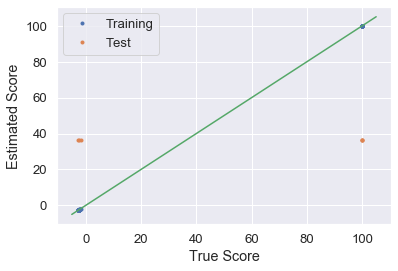

In [277]:
# Full model
n = 45
x_data = np.array(x_iters_full)
y_data = np.array(func_vals_full)
x_train = x_data[:n, :]
y_train = y_data[:n]
x_test = x_data[n:, :]
y_test = y_data[n:]

gpr = GaussianProcessRegressor(kernel=1**2*kernels.Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) +
                               kernels.WhiteKernel(noise_level=1), n_restarts_optimizer=2,
                               normalize_y=True, random_state=209652396)
gpr.fit(x_train, y_train)
print(f'Training Error: {np.linalg.norm(y_train - gpr.predict(x_train))/np.linalg.norm(y_train):.4f}')
print(f'Test Error: {np.linalg.norm(y_test - gpr.predict(x_test))/np.linalg.norm(y_test):.4f}')
plt.plot(y_train, gpr.predict(x_train), '.')
plt.plot(y_test, gpr.predict(x_test), '.')
plt.plot([-5, 105], [-5, 105])
plt.xlabel('True Score')
plt.ylabel('Estimated Score')
plt.legend(['Training', 'Test']);

Training Error: 0.0100
Test Error: 0.0124


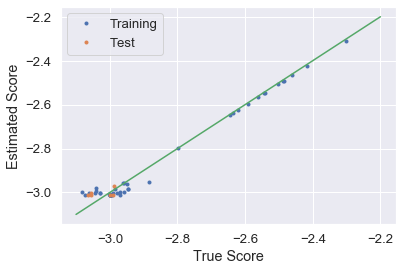

In [276]:
# Quarter model
n = 45
x_data = np.array(x_iters_quarter)
y_data = np.array(func_vals_quarter)
x_train = x_data[:n, :]
y_train = y_data[:n]
x_test = x_data[n:, :]
y_test = y_data[n:]

gpr = GaussianProcessRegressor(kernel=1**2*kernels.Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) +
                               kernels.WhiteKernel(noise_level=1), n_restarts_optimizer=2,
                               normalize_y=True, random_state=209652396)
gpr.fit(x_train, y_train)
print(f'Training Error: {np.linalg.norm(y_train - gpr.predict(x_train))/np.linalg.norm(y_train):.4f}')
print(f'Test Error: {np.linalg.norm(y_test - gpr.predict(x_test))/np.linalg.norm(y_test):.4f}')
plt.plot(y_train, gpr.predict(x_train), '.')
plt.plot(y_test, gpr.predict(x_test), '.')
plt.plot([-3.1, -2.2], [-3.1, -2.2])
plt.xlabel('True Score')
plt.ylabel('Estimated Score')
plt.legend(['Training', 'Test']);

Training Error: 0.0010
Test Error: 0.0170


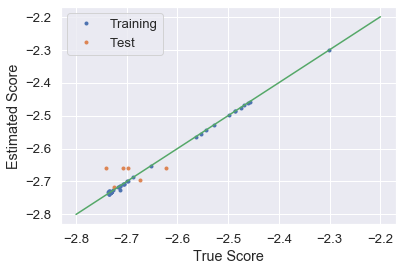

In [278]:
# Half model
n = 45
x_data = np.array(x_iters_half)
y_data = np.array(func_vals_half)
x_train = x_data[:n, :]
y_train = y_data[:n]
x_test = x_data[n:, :]
y_test = y_data[n:]

gpr = GaussianProcessRegressor(kernel=1**2*kernels.Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) +
                               kernels.WhiteKernel(noise_level=1), n_restarts_optimizer=2,
                               normalize_y=True, random_state=209652396)
gpr.fit(x_train, y_train)
print(f'Training Error: {np.linalg.norm(y_train - gpr.predict(x_train))/np.linalg.norm(y_train):.4f}')
print(f'Test Error: {np.linalg.norm(y_test - gpr.predict(x_test))/np.linalg.norm(y_test):.4f}')
plt.plot(y_train, gpr.predict(x_train), '.')
plt.plot(y_test, gpr.predict(x_test), '.')
plt.plot([-2.8, -2.2], [-2.8, -2.2])
plt.xlabel('True Score')
plt.ylabel('Estimated Score')
plt.legend(['Training', 'Test']);

Now I look at the error for each point based on the model fit to the previous points. Since the solver selects sample points based on a balance between exploration and exploitation, I think it makes sense that the estimates don't steadily decrease as we iterate. 

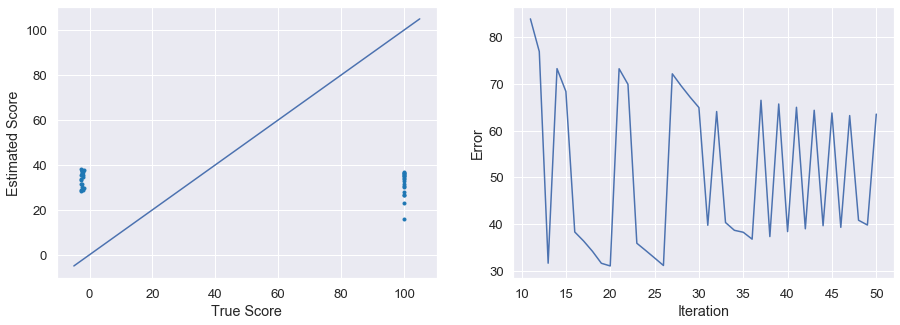

In [319]:
# Full model
err = []
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for ii in range(11, 51):
    x_data = np.array(x_iters_full[:ii])
    y_data = np.array(func_vals_full[:ii])
    gpr = GaussianProcessRegressor(kernel=1**2*kernels.Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) +
                                   kernels.WhiteKernel(noise_level=1), n_restarts_optimizer=2,
                                   normalize_y=True, random_state=209652396)
    gpr.fit(x_data, y_data)
    y_true = func_vals_full[ii]
    y_pred = gpr.predict(np.array(x_iters_full[ii]).reshape(1, -1))
    ax[0].plot(y_true, y_pred, '.', color=colors[0])
    err.append(abs(y_true - y_pred))
ax[0].plot([-5, 105], [-5, 105])
ax[0].set_xlabel('True Score')
ax[0].set_ylabel('Estimated Score')
ax[1].plot(np.arange(11, 51), err)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Error');

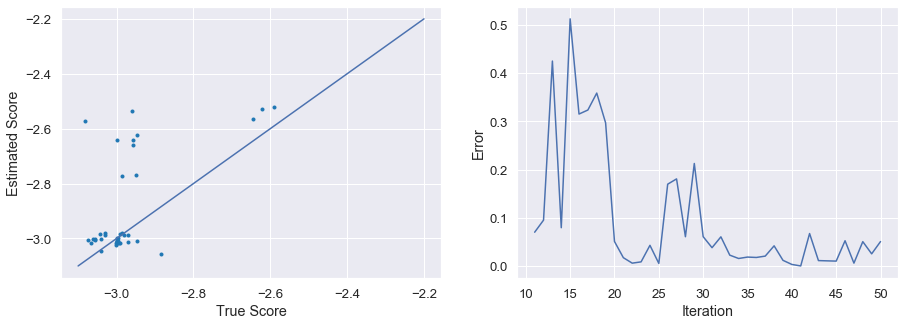

In [320]:
# Quarter model
err = []
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for ii in range(11, 51):
    x_data = np.array(x_iters_quarter[:ii])
    y_data = np.array(func_vals_quarter[:ii])
    gpr = GaussianProcessRegressor(kernel=1**2*kernels.Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) +
                                   kernels.WhiteKernel(noise_level=1), n_restarts_optimizer=2,
                                   normalize_y=True, random_state=209652396)
    gpr.fit(x_data, y_data)
    y_true = func_vals_quarter[ii]
    y_pred = gpr.predict(np.array(x_iters_quarter[ii]).reshape(1, -1))
    ax[0].plot(y_true, y_pred, '.', color=colors[0])
    err.append(abs(y_true - y_pred))
ax[0].plot([-3.1, -2.2], [-3.1, -2.2])
ax[0].set_xlabel('True Score')
ax[0].set_ylabel('Estimated Score')
ax[1].plot(np.arange(11, 51), err)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Error');

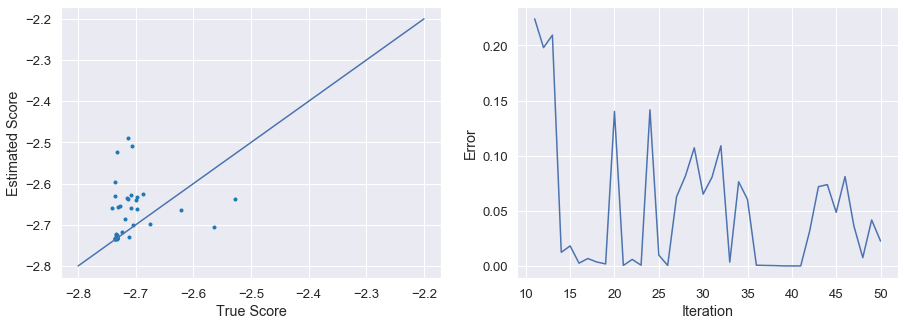

In [317]:
# Half model
err = []
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for ii in range(11, 51):
    x_data = np.array(x_iters_half[:ii])
    y_data = np.array(func_vals_half[:ii])
    gpr = GaussianProcessRegressor(kernel=1**2*kernels.Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) +
                                   kernels.WhiteKernel(noise_level=1), n_restarts_optimizer=2,
                                   normalize_y=True, random_state=209652396)
    gpr.fit(x_data, y_data)
    y_true = func_vals_half[ii]
    y_pred = gpr.predict(np.array(x_iters_half[ii]).reshape(1, -1))
    ax[0].plot(y_true, y_pred, '.', color=colors[0])
    err.append(abs(y_true - y_pred))
ax[0].plot([-2.8, -2.2], [-2.8, -2.2])
ax[0].set_xlabel('True Score')
ax[0].set_ylabel('Estimated Score')
ax[1].plot(np.arange(11, 51), err)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Error');

Based on my previous sampling, I was concerned that using all of the parameters in the model, rather than just the one with the highest correlation, would lead to overfitting and always predicting the mean value. However, this doesn't seem to be the case for the two examples where we didn't have to deal with infeasibility. This is great news!